In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.axes import Axes
import xesmf as xe
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate

/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
data_dir = 'ocean_con_temp.res.nc'  # daily
ds_contemp_i = xr.open_dataset(data_dir)

data_dir = 'ocean_temp_salt.res.nc'  # daily
ds_temp_salt = xr.open_dataset(data_dir)

data_dir = 'grid_spec.nc'  # daily
ds_grid_spec_720x410 = xr.open_dataset(data_dir)

data_dir = 'grid_spec_192_94_360_200.nc'  # daily
ds_grid_spec_360x200 = xr.open_dataset(data_dir)

In [4]:
ds_contemp_i

<xarray.Dataset>
Dimensions:   (Time: 1, xaxis_1: 360, yaxis_1: 200, zaxis_1: 50)
Coordinates:
  * xaxis_1   (xaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 357.0 358.0 359.0 360.0
  * yaxis_1   (yaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 197.0 198.0 199.0 200.0
  * zaxis_1   (zaxis_1) float64 1.0 2.0 3.0 4.0 5.0 ... 46.0 47.0 48.0 49.0 50.0
  * Time      (Time) float64 1.0
Data variables:
    con_temp  (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
Attributes:
    filename:  RESTART/18821001.000000.ocean_con_temp.res.nc

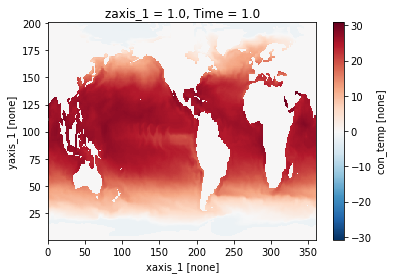

In [6]:
ds_contemp_i.con_temp.isel(zaxis_1=0).plot()

In [7]:
ds_contemp_i['xaxis_1'] = ds_grid_spec_360x200.gridlon_t.values
ds_contemp_i['yaxis_1'] = ds_grid_spec_360x200.gridlat_t.values
ds_contemp_i['zaxis_1'] = ds_grid_spec_360x200.zt.values

In [8]:
ds_contemp_i

<xarray.Dataset>
Dimensions:   (Time: 1, xaxis_1: 360, yaxis_1: 200, zaxis_1: 50)
Coordinates:
  * xaxis_1   (xaxis_1) float32 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yaxis_1   (yaxis_1) float32 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
  * zaxis_1   (zaxis_1) float32 5.0 15.0 25.0 ... 4587.7427 4950.4087 5316.4287
  * Time      (Time) float64 1.0
Data variables:
    con_temp  (Time, zaxis_1, yaxis_1, xaxis_1) float64 ...
Attributes:
    filename:  RESTART/18821001.000000.ocean_con_temp.res.nc

In [9]:
zt = ds_grid_spec_360x200.zt.values
zt1 = np.zeros((zt.shape[0]+1))
zt1[0] = zt[0]/2
zt1[-1] = zt[-1] + ((zt[-1] - zt[-2])/2)
for i in range(1,zt1.shape[0]-1):
    zt1[i] = (zt[i] + zt[i-1])/2

In [10]:
ds_out = xr.Dataset({'lat': (['lat'], ds_grid_spec_720x410.grid_y_T.values),
                     'lon': (['lon'], ds_grid_spec_720x410.grid_x_T.values),
                     'lev': (['lev'], ds_grid_spec_720x410.zt.values),
                    }
                   )
ds_contemp_i_ = ds_contemp_i.rename({
  "yaxis_1": "lat",
  "xaxis_1": "lon",
  "zaxis_1": "lev"
})

In [11]:
regridder = xe.Regridder(ds_contemp_i_, ds_out, 'bilinear')

Create weight file: bilinear_200x360_410x720.nc


In [12]:
regridder.clean_weight_file()

Remove file bilinear_200x360_410x720.nc


In [13]:
ds_contemp_o = regridder(ds_contemp_i)

using dimensions ('yaxis_1', 'xaxis_1') from data variable con_temp as the horizontal dimensions for this dataset.


/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [14]:
ds_contemp_o

<xarray.Dataset>
Dimensions:   (Time: 1, lat: 410, lon: 720, zaxis_1: 50)
Coordinates:
  * zaxis_1   (zaxis_1) float32 5.0 15.0 25.0 ... 4587.7427 4950.4087 5316.4287
  * Time      (Time) float64 1.0
  * lon       (lon) float32 -279.75 -279.25 -278.75 ... 78.75 79.25 79.75
  * lat       (lat) float32 -80.75 -80.25 -79.75 -79.25 ... 88.75 89.25 89.75
Data variables:
    con_temp  (Time, zaxis_1, lat, lon) float64 0.0 0.01528 0.01528 ... 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [15]:
def vinterp(field, levold, levnew):
    coords =  {'lat': field.lat.values, 'lon': field.lon.values, 'lev': levnew, 'Time': field.Time.values}
    dummy = np.zeros((field.Time.values.shape[0], levnew.shape[0], field.lat.values.shape[0], field.lon.values.shape[0]))
    field_o_ = xr.DataArray(data=dummy, coords=coords, dims=['Time', 'lev', 'lat', 'lon'])
    field_o = xr.Dataset(data_vars={"dummy": field_o_})
    for ii in field.data_vars:
        print(field[ii].name)
        if (len(field[ii].shape)==3):
            field_o[ii] = (('Time', 'lat', 'lon'),  field[ii].values)
        else:
            orig   = np.zeros((levold.shape[0], field[ii].shape[2], field[ii].shape[3]))
            interp = np.zeros((levnew.shape[0], field[ii].shape[2], field[ii].shape[3]))
            orig = field[ii].values[0,:,:,:]
            for i in range(field[ii].shape[2]):
                for j in range(field[ii].shape[3]):
                    f = interpolate.interp1d(levold, orig[:,i,j])
                    interp[:,i,j] = f(levnew)
            interp = np.expand_dims(interp, axis=0)
            field_o[ii] = (('Time', 'lev','lat', 'lon'),  interp)
    field_o = field_o.drop('dummy')
    return field_o

In [16]:
ds_contemp_o_ = vinterp(ds_contemp_o, ds_grid_spec_360x200.zt.values, ds_grid_spec_720x410.zt.values)

con_temp


In [18]:
ds_contemp_o = ds_contemp_o_.rename({
  "lat": "yaxis_1",
  "lon": "xaxis_1",
  "lev": "zaxis_1",
})

In [23]:
x = ds_contemp_o.xaxis_1.values
ds_contemp_o['xaxis_1'] = np.arange(x.shape[0], dtype=np.double)

y = ds_contemp_o.yaxis_1.values
ds_contemp_o['yaxis_1'] = np.arange(y.shape[0], dtype=np.double)

z = ds_contemp_o.zaxis_1.values
ds_contemp_o['zaxis_1'] = np.arange(z.shape[0], dtype=np.double)

ds_contemp_o.xaxis_1.attrs['long_name'] = 'xaxis_1'
ds_contemp_o.xaxis_1.attrs['units'] = 'xaxis_1'
ds_contemp_o.xaxis_1.attrs['cartesian_axis'] = 'X'

ds_contemp_o.yaxis_1.attrs['long_name'] = 'yaxis_1'
ds_contemp_o.yaxis_1.attrs['units'] = 'yaxis_1'
ds_contemp_o.yaxis_1.attrs['cartesian_axis'] = 'Y'

ds_contemp_o.zaxis_1.attrs['long_name'] = 'zaxis_1'
ds_contemp_o.zaxis_1.attrs['units'] = 'zaxis_1'
ds_contemp_o.zaxis_1.attrs['cartesian_axis'] = 'Z'

ds_contemp_o.con_temp.attrs['long_name'] = 'con_temp'
ds_contemp_o.con_temp.attrs['units'] = 'none'

In [24]:
ds_contemp_o.to_netcdf('ocean_con_temp.res.regrid.nc')